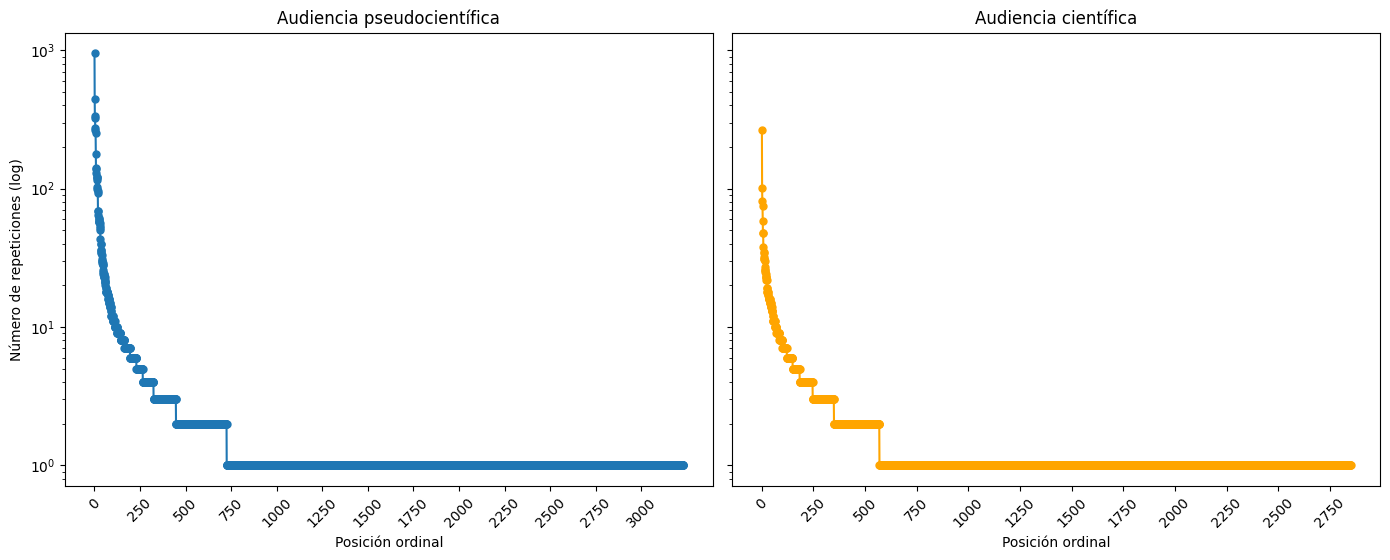

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

# Función para procesar un DataFrame y devolver el log y el DataFrame de variantes
def procesar_dataframe(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['activity'] = df['Tematica del comentario'] + " - " + df['emotion']
    event_log = df.rename(columns={
        'conversation_id': 'case:concept:name',
        'timestamp': 'time:timestamp',
        'activity': 'concept:name',
    })
    log = log_converter.apply(event_log)
    variantes = pm4py.get_variants_as_tuples(log)
    variantes_df = pd.DataFrame({
        'Variantes': list(variantes.keys()),
        'Repeticiones': [len(v) for v in variantes.values()]
    }).sort_values(by='Repeticiones', ascending=False).reset_index(drop=True)
    return variantes_df

# === Dataset pseudocientífico ===
df1 = pd.read_csv("Evaluated final datasets/Evaluated_pseudo_1.csv")
df2 = pd.read_csv("Evaluated final datasets/Evaluated_pseudo_2.csv")
pseudo_df = pd.concat([df1, df2], ignore_index=True)

# Renombrar la última columna
ultima_columna = pseudo_df.columns[-1]
pseudo_df = pseudo_df.rename(columns={ultima_columna: 'Tematica del comentario'})

# Procesar
variantes_pseudo_df = procesar_dataframe(pseudo_df)

# === Dataset científico ===
scientific_df = pd.read_csv("Evaluated final datasets/Evaluated_scientific.csv")
scientific_df = scientific_df.iloc[:, 1:]
scientific_df['timestamp'] = pd.to_datetime(scientific_df['timestamp'])
variantes_scientific_df = procesar_dataframe(scientific_df)

# === Graficar ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Gráfico pseudocientífico
axes[0].plot(variantes_pseudo_df.index + 1, variantes_pseudo_df['Repeticiones'], 'o-', markersize=5)
axes[0].set_yscale('log')
axes[0].set_title('Audiencia pseudocientífica')
axes[0].set_xlabel('Posición ordinal')
axes[0].set_ylabel('Número de repeticiones (log)')

# Ajustar etiquetas del eje X (cada 5 posiciones) y rotarlas 45 grados
axes[0].set_xticks(variantes_pseudo_df.index[::250])  # Mostrar cada 5 etiquetas
axes[0].tick_params(axis='x', rotation=45)  # Rotar 45 grados

# Gráfico científico
axes[1].plot(variantes_scientific_df.index + 1, variantes_scientific_df['Repeticiones'], 'o-', color='orange', markersize=5)
axes[1].set_yscale('log')
axes[1].set_title('Audiencia científica')
axes[1].set_xlabel('Posición ordinal')

# Ajustar etiquetas del eje X (cada 5 posiciones) y rotarlas 45 grados
axes[1].set_xticks(variantes_scientific_df.index[::250])  # Mostrar cada 5 etiquetas
axes[1].tick_params(axis='x', rotation=45)  # Rotar 45 grados

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("variantes_comparadas.png", dpi=300, bbox_inches='tight')  # Mejor calidad y ajuste
plt.show()

Distribución de longitudes de conversaciones:
 Longitud (mensajes)  Número de conversaciones
                   2                      8682
                   3                      1435
                   4                       461
                   5                       225
                   6                       141
                   7                        80
                   8                        43
                   9                        38
                  10                        39
                  11                        22
                  12                        17
                  13                        14
                  14                        12
                  15                         7
                  16                        11
                  17                         5
                  18                         5
                  19                         7
                  20                        10
              

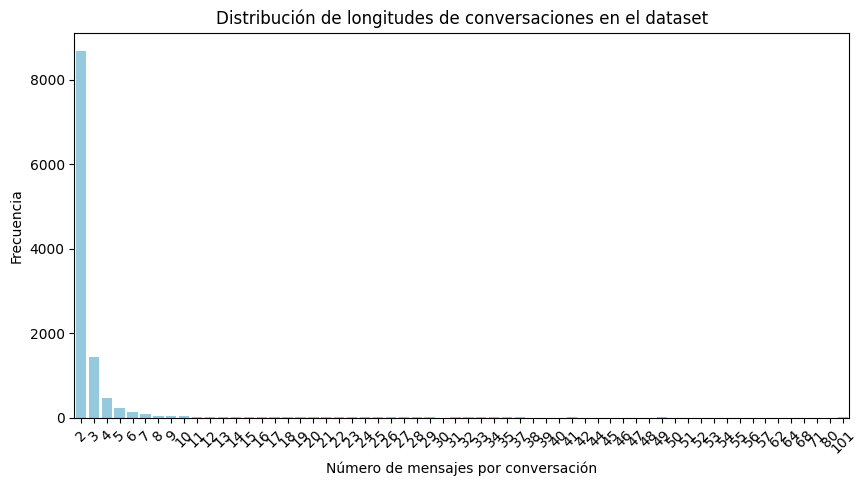

In [21]:
import seaborn as sns
# Calcular la longitud de cada conversación (número de mensajes por conversation_id)
longitud_conversaciones = pseudo_df.groupby('conversation_id').size().reset_index(name='longitud')

# Contar la frecuencia de cada longitud
distribucion_longitud = longitud_conversaciones['longitud'].value_counts().sort_index().reset_index()
distribucion_longitud.columns = ['Longitud (mensajes)', 'Número de conversaciones']

# Mostrar la tabla completa
print("Distribución de longitudes de conversaciones:")
print(distribucion_longitud.to_string(index=False))

# Gráfico de barras
plt.figure(figsize=(10, 5))
sns.barplot(x='Longitud (mensajes)', y='Número de conversaciones', data=distribucion_longitud, color='skyblue')
plt.title('Distribución de longitudes de conversaciones en el dataset')
plt.xlabel('Número de mensajes por conversación')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [19]:
# Para el dataset pseudocientífico
total_conversaciones_pseudo = pseudo_df['conversation_id'].nunique()
variantes_repetidas_pseudo = variantes_pseudo_df[variantes_pseudo_df['Repeticiones'] > 1]
porcentaje_repetidas_pseudo = (variantes_repetidas_pseudo['Repeticiones'].sum() / total_conversaciones_pseudo) * 100

# Para el dataset científico
total_conversaciones_sci = scientific_df['conversation_id'].nunique()
variantes_repetidas_sci = variantes_scientific_df[variantes_scientific_df['Repeticiones'] > 1]
porcentaje_repetidas_sci = (variantes_repetidas_sci['Repeticiones'].sum() / total_conversaciones_sci) * 100

print(f"Pseudociencia: {porcentaje_repetidas_pseudo:.2f}% de conversaciones son variantes repetidas")
print(f"Ciencia: {porcentaje_repetidas_sci:.2f}% de conversaciones son variantes repetidas")

Pseudociencia: 77.91% de conversaciones son variantes repetidas
Ciencia: 60.67% de conversaciones son variantes repetidas


In [29]:
def porcentaje_acumulado_variantes(variantes_df, total_conversaciones, n_variantes):
    """
    Calcula el porcentaje acumulado de conversaciones cubiertas por las N primeras variantes.
    
    Args:
        variantes_df (DataFrame): DataFrame de variantes (columnas: 'Variantes', 'Repeticiones').
        total_conversaciones (int): Número total de conversaciones únicas.
        n_variantes (int): Número de variantes a considerar (top-N).
    
    Returns:
        float: Porcentaje acumulado.
    """
    variantes_top_n = variantes_df.head(n_variantes)
    conversaciones_cubiertas = variantes_top_n['Repeticiones'].sum()
    return (conversaciones_cubiertas / total_conversaciones) * 100


# Calcular el total de conversaciones únicas
total_conversaciones_pseudo = pseudo_df['conversation_id'].nunique()

# Porcentaje cubierto por las primeras 10 variantes
porcentaje_pseudo = porcentaje_acumulado_variantes(variantes_pseudo_df, total_conversaciones_pseudo, n_variantes=15)
print(f"Pseudociencia - Top 10 variantes cubren el {porcentaje_pseudo:.2f}% de conversaciones")


total_conversaciones_sci = scientific_df['conversation_id'].nunique()
porcentaje_sci = porcentaje_acumulado_variantes(variantes_scientific_df, total_conversaciones_sci, n_variantes=20)
print(f"Ciencia - Top 10 variantes cubren el {porcentaje_sci:.2f}% de conversaciones")

Pseudociencia - Top 10 variantes cubren el 34.42% de conversaciones
Ciencia - Top 10 variantes cubren el 18.22% de conversaciones
